# 🛠️Preparação do ambiente:

1. **Definição do Catálogo:**  
   Foi selecionado o catálogo `100cep_gateway`, que organiza e gerencia os dados do projeto dentro do ambiente Databricks.

2. **Seleção do Schema:**  
   O schema `gold` foi definido, indicando que as análises e consultas serão realizadas sobre as tabelas refinadas e validadas, típicas da camada "gold" em projetos de dados.

3. **Configuração de Bibliotecas:**  
   Foram instaladas e importadas as principais bibliotecas para análise e visualização de dados: `pandas`, `matplotlib` e `seaborn`. Isso garante que o ambiente está pronto para manipulação de dados e geração de gráficos.

Essas etapas são fundamentais para garantir que todas as análises subsequentes sejam realizadas sobre dados organizados, confiáveis e com o suporte das ferramentas adequadas, seguindo boas práticas de projetos de dados.

In [0]:
%sql
USE CATALOG `100cep_gateway`;

In [0]:
%sql
USE SCHEMA gold;

In [0]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install geopandas 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


# 🔍 Perguntas de Negócio (Insights)

A 100cep Gateway é uma empresa fictícia de infraestrutura de pagamentos borderless, especializada em processar pagamentos globais de forma rápida, segura e interoperável. Nosso objetivo é permitir **transações rápidas**, **seguras** e **sem fronteiras** — afinal, somos _100cep_: sem _cidade_, _estado_ ou _país_ limitando o fluxo dos pagamentos.

As perguntas abaixo orientam a análise dos dados do projeto, buscando insights relevantes para o negócio:

1. **Qual o método de pagamento mais utilizado pelos clientes da 100cep Gateway?**  
   Entender o método de pagamento predominante entre os clientes revela preferências e auxilia na negociação com parceiros financeiros, além de direcionar estratégias para facilitar o processo de compra.

   A análise dos dados de transações indica que a modalidade **cartão de crédito** é a mais utilizada pelos clientes da 100cep Gateway, destacando-se com o maior número de ocorrências em comparação aos demais métodos disponíveis. Esse resultado sugere que os clientes valorizam a praticidade, a possibilidade de parcelamento e os benefícios associados ao uso do cartão de crédito, como programas de pontos e maior segurança nas transações.

   Essa preferência impacta diretamente as estratégias comerciais e operacionais da empresa, pois reforça a importância de manter parcerias sólidas com operadoras de cartão, investir em tecnologias antifraude específicas para esse meio de pagamento e oferecer condições atrativas para estimular ainda mais seu uso. Além disso, o monitoramento contínuo desse indicador permite identificar mudanças no comportamento dos clientes e antecipar tendências, como o crescimento de carteiras digitais ou outros métodos alternativos.

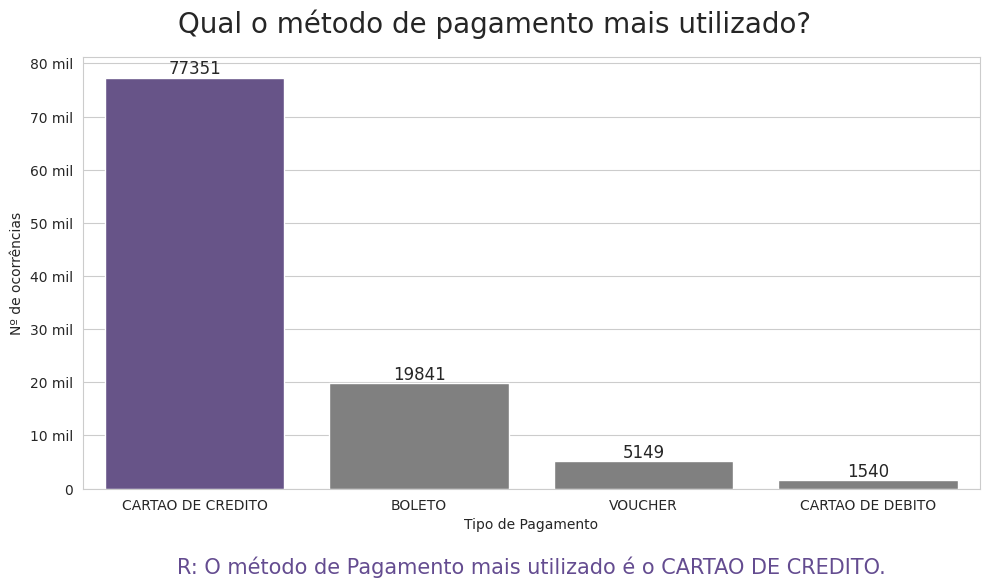

In [0]:
# Consulta SQL para obter o total de ocorrências por tipo de pagamento
df = spark.sql("""
SELECT 
  tipo_pagamento,
  COUNT(tipo_pagamento) AS total
FROM 
    fato_transacoes
GROUP BY 
    tipo_pagamento
ORDER BY 
    total DESC
""")

# Converte o DataFrame Spark para Pandas para visualização
pdf = df.toPandas()

# Identifica o índice do método mais utilizado
max_idx = pdf['total'].idxmax()

# Obtém o nome do método de pagamento mais utilizado
metodo_mais_utilizado = pdf.loc[max_idx, 'tipo_pagamento']

# Define cores para destacar o método mais utilizado
cores = ['#644c90' if i == max_idx else '#808080' for i in range(len(pdf))]

# Cria o gráfico de barras dos métodos de pagamento
plt.figure(figsize=(10, 6))  # Ajusta para preencher a tela inteira
sns.set_style("whitegrid")

a = sns.barplot(
    x='tipo_pagamento',
    y='total',
    data=pdf,
    hue='tipo_pagamento',
    palette=cores,
    dodge=False
)

# Título do gráfico
a.get_figure().suptitle('Qual o método de pagamento mais utilizado?', fontsize=20)

# Rótulos dos eixos
a.set(
    xlabel='Tipo de Pagamento',
    ylabel='Nº de ocorrências'
)

from matplotlib.ticker import FuncFormatter

# Função para formatar os valores do eixo Y como "X mil" se terminar com três zeros
def mil_formatter(x, pos):
    if x >= 1000 and x % 1000 == 0:
        return f'{int(x/1000)} mil'
    return f'{int(x)}'

a.yaxis.set_major_formatter(FuncFormatter(mil_formatter))

# Adiciona rótulos de valor em cada barra
for i, bar in enumerate(a.patches):
    a.annotate(
        f"{int(bar.get_height())}",
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=12
    )

# Adiciona resposta destacada abaixo do gráfico
a.text(
    0.5, -0.18,
    f'R: O método de Pagamento mais utilizado é o {metodo_mais_utilizado}.',
    ha='center', va='center', fontsize=15, color='#644c90', transform=a.transAxes
)

# Exibe o gráfico
plt.tight_layout()
plt.show()

2. **Qual o histórico de faturamento do ano de 2017?**  
   Analisar o faturamento mensal ao longo de 2017 permite identificar variações de receita, sazonalidades e períodos de maior desempenho financeiro, auxiliando no planejamento estratégico e na tomada de decisões para o crescimento do negócio.

   Observando os dados, percebe-se uma forte tendência de crescimento do faturamento ao longo dos meses. Em janeiro, a empresa começou faturando cerca de R$ 137 mil, e atingiu seu pico em novembro, com o faturamento na casa dos R$ 1,2 milhão. Esse aumento consistente sugere uma expansão significativa das operações, possivelmente impulsionada por estratégias comerciais bem-sucedidas, aumento da base de clientes ou lançamento de novos produtos e serviços.

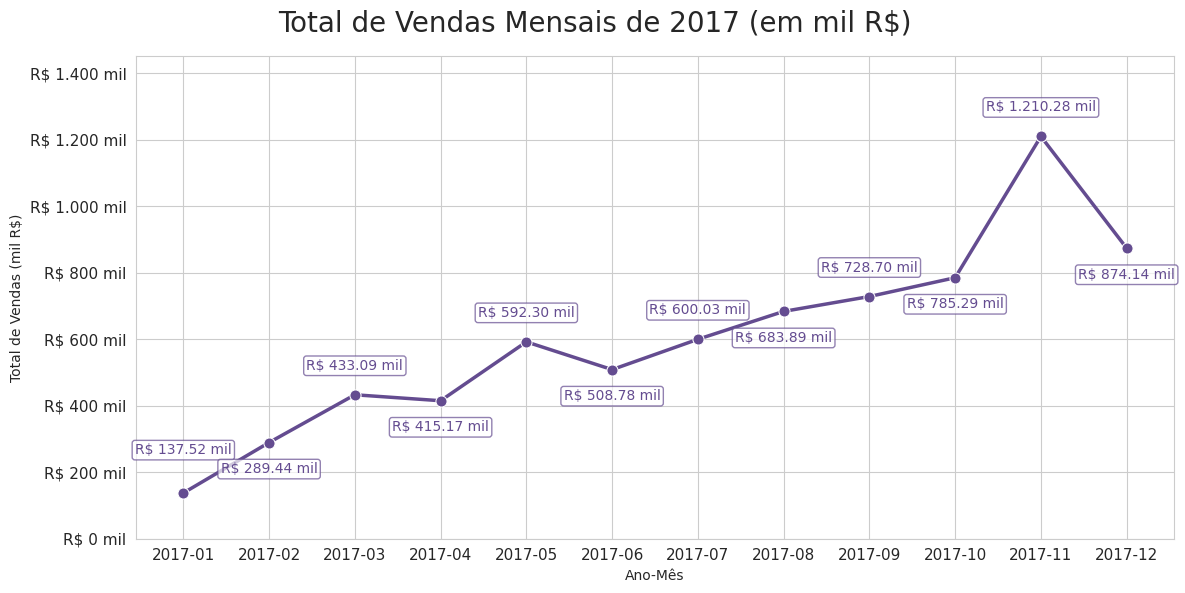

In [0]:
df = spark.sql("""
SELECT 
  CONCAT(d.d_year, '-', LPAD(d.d_moy, 2, '0')) AS ano_mes,
  ROUND(SUM(f.valor_transacao) / 1000, 2) AS total_vendas_mil
FROM 
  samples.tpcds_sf1000.date_dim AS d
LEFT JOIN 
  fato_transacoes AS f
ON 
  d.d_date = f.data_pedido
WHERE 
  d.d_year = 2017
GROUP BY 
  d.d_year, d.d_moy
ORDER BY 
  ano_mes
""")

pdf = df.toPandas()
pdf['total_vendas_mil'] = pdf['total_vendas_mil'].astype(float)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

a = sns.lineplot(
    x='ano_mes',
    y='total_vendas_mil',
    data=pdf,
    marker='o',
    color='#644c90',
    linewidth=2.5,
    markersize=8
)

a.get_figure().suptitle(
    'Total de Vendas Mensais de 2017 (em mil R$)', 
    fontsize=20
)
a.set(
    xlabel='Ano-Mês',
    ylabel='Total de Vendas (mil R$)'
)

from matplotlib.ticker import FuncFormatter, MaxNLocator

def mil_reais_formatter(x, pos):
    return f'R$ {x:,.0f} mil'.replace(',', '.')

a.set_ylim(
    bottom=0, 
    top=(pdf['total_vendas_mil'].max() + pdf['total_vendas_mil'].max() * 0.2)
)
a.yaxis.set_major_locator(MaxNLocator(nbins=8, integer=True))
a.yaxis.set_major_formatter(FuncFormatter(mil_reais_formatter))

for i, (x, y) in enumerate(zip(pdf['ano_mes'], pdf['total_vendas_mil'])):
    offset = 18 if i % 2 == 0 else -22
    if y < pdf['total_vendas_mil'].max() * 0.15:
        offset += 10 if offset > 0 else -10
    a.annotate(
        f"R$ {y:,.2f} mil".replace(',', '.'),
        (x, y),
        textcoords="offset points",
        xytext=(0, offset),
        ha='center',
        fontsize=10,
        color='#644c90',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#644c90", alpha=0.7)
    )

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

3. **Qual a proporção de pedidos com e sem solicitação de chargeback?**  
   Avaliar a proporção de pedidos que sofreram chargeback em relação ao total de transações é fundamental para mensurar o nível de risco operacional e a eficiência dos controles antifraude. Esse indicador permite identificar se o volume de chargebacks está dentro do esperado para o setor, além de embasar decisões para aprimorar políticas de prevenção e mitigar perdas financeiras.

   Verificou-se que apenas 3,43% dos pedidos resultaram em chargeback, totalizando R$ 582.406,16, enquanto 96,57% das transações foram concluídas normalmente, sem esse tipo de solicitação. Isso demonstra que, apesar de a maioria das operações ocorrer sem contestação, o chargeback ainda representa um grande ponto de atenção para a empresa.

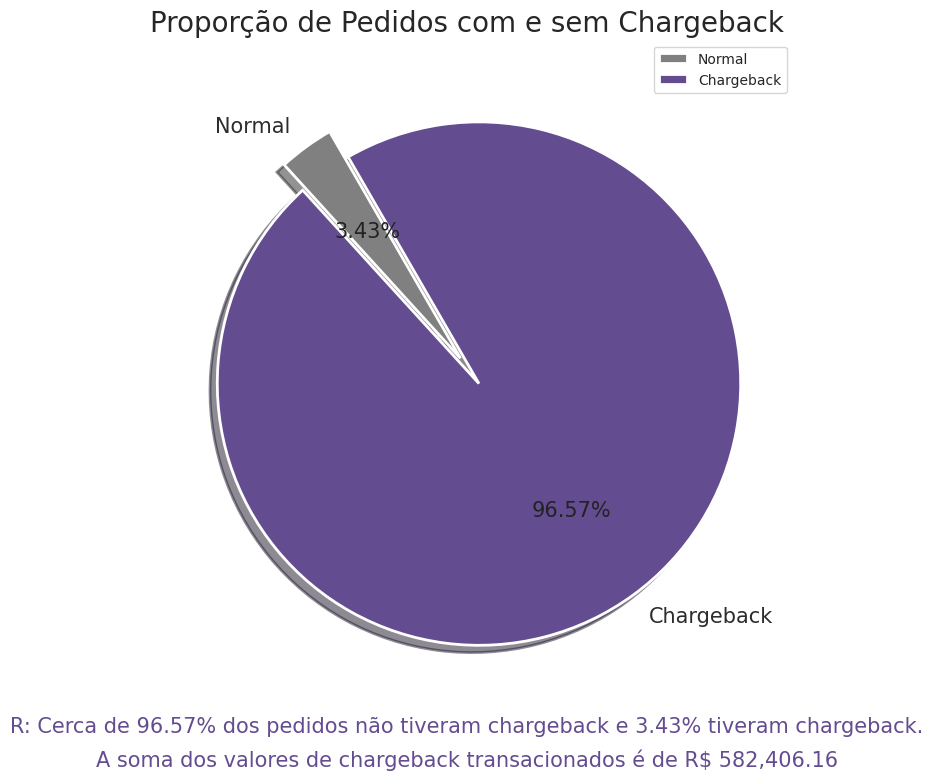

In [0]:
df = spark.sql("""
SELECT 
  CASE WHEN chargeback_id IS NOT NULL THEN 'SIM' ELSE 'NAO' END AS teve_chargeback,
  ROUND(
    100.0 * COUNT(*) / SUM(COUNT(*)) OVER (),
    2
  ) AS percentual
FROM 
  fato_transacoes
LEFT JOIN
  dim_chargebacks
ON
  fato_transacoes.pedido_id = dim_chargebacks.chargeback_id
GROUP BY
  CASE WHEN chargeback_id IS NOT NULL THEN 'SIM' ELSE 'NAO' END
""")

pdf = df.toPandas()

# Obtém o valor total de chargeback
valor_chargeback = spark.sql("""
SELECT 
  SUM(CASE WHEN chargeback_id IS NOT NULL THEN valor_transacao ELSE 0 END) AS total_chargeback
FROM 
  fato_transacoes
LEFT JOIN
  dim_chargebacks
ON
  fato_transacoes.pedido_id = dim_chargebacks.chargeback_id
""").collect()[0]['total_chargeback']

labels = ['Normal', 'Chargeback']
sizes = pdf['percentual']
explode = [0.08 if v == max(sizes) else 0.04 for v in sizes]
colors = ['#808080', '#644c90']

plt.figure(figsize=(9, 9), facecolor='white')
plt.gca().set_aspect('equal')

patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=120,
    explode=explode,
    colors=colors,
    shadow=True,
    textprops={'fontsize': 15, 'color': '#222222'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}
)

for text in texts:
    text.set_fontsize(15)
    text.set_color('#2C2C2C')

for autotext in autotexts:
    autotext.set_color('#222222')
    autotext.set_fontsize(15)

plt.title(
    'Proporção de Pedidos com e sem Chargeback',
    fontsize=20
)

plt.legend(
    patches, labels
)

plt.gca().text(
    0.5, -0.05,
    f'R: Cerca de {max(sizes)}% dos pedidos não tiveram chargeback e {min(sizes)}% tiveram chargeback.',
    ha='center', va='center', fontsize=15, color='#644c90', transform=plt.gca().transAxes,
)

plt.gca().text(
    0.5, -0.1,
    f'A soma dos valores de chargeback transacionados é de R$ {valor_chargeback:,.2f}',
    ha='center', va='center', fontsize=15, color='#644c90', transform=plt.gca().transAxes,
)

plt.tight_layout()
plt.show()

4. **Quais métodos de pagamento têm maior risco de chargeback?**  
   Analisar os métodos com maior incidência de chargebacks é fundamental para mitigar riscos financeiros, ajustar políticas de pagamento e implementar medidas de segurança.

   Observou-se que o método de pagamento que apresenta maior risco proporcional de chargeback é o VOUCHER, com uma taxa de 6,84%. Isso significa que, a cada 100 transações realizadas via voucher, aproximadamente 7 resultam em chargeback, o que representa um risco significativamente superior ao dos demais métodos. Os outros métodos, como cartão de crédito, boleto e carteiras digitais, apresentaram taxas próximas de 3%, indicando um risco mais controlado nessas modalidades. Possíveis causas para o maior índice podem estar relacionadas à facilidade de obtenção e uso de vouchers, menor rastreabilidade ou até mesmo campanhas promocionais que atraem tentativas de fraude.

/home/spark-1fd7dc25-b7a9-439d-9f7e-e7/.ipykernel/3408/command-7372621890615817-1752343005:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.barplot(


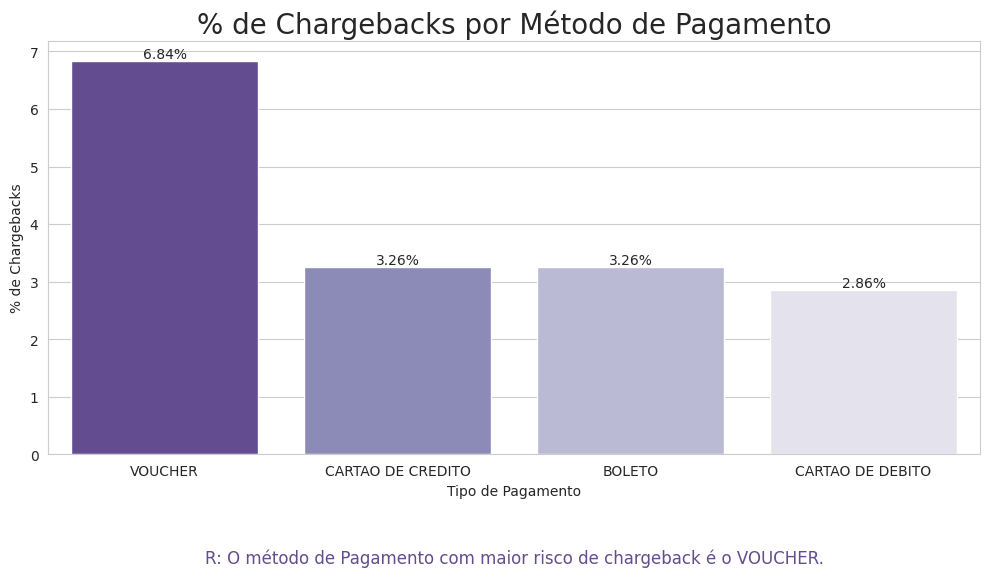

In [0]:
df = spark.sql("""
WITH chargebacks_por_tipo AS (
  SELECT 
    ft.tipo_pagamento AS metodo_pagamento,
    COUNT(*) AS n_chargebacks
  FROM 
    dim_chargebacks AS cb
  LEFT JOIN 
    fato_transacoes AS ft
  ON
    ft.pedido_id = cb.chargeback_id
  GROUP BY
    ft.tipo_pagamento
)
SELECT 
  ft.tipo_pagamento,
  ROUND((cbt.n_chargebacks / COUNT(*))*100,2) AS percentual_chargebacks
FROM 
  fato_transacoes AS ft
LEFT JOIN
  dim_chargebacks AS cb
ON
  ft.pedido_id = cb.chargeback_id
LEFT JOIN
  chargebacks_por_tipo AS cbt
ON
  cbt.metodo_pagamento = ft.tipo_pagamento
GROUP BY
  ft.tipo_pagamento,
  cbt.n_chargebacks
ORDER BY
  percentual_chargebacks DESC
""")
pdf = df.toPandas()

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

palette = list(reversed(sns.color_palette("Purples", len(pdf))))

a = sns.barplot(
    x='tipo_pagamento',
    y='percentual_chargebacks',
    data=pdf,
    palette=palette,
)
a.set(
    title='% de Chargebacks por Método de Pagamento',
    xlabel='Tipo de Pagamento',
    ylabel='% de Chargebacks'
)
a.set_title('% de Chargebacks por Método de Pagamento', fontsize=20)
for i, bar in enumerate(a.patches):
    a.annotate(
        f"{bar.get_height():.2f}%",
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=10
    )

max_idx = pdf['percentual_chargebacks'].idxmax()
a.text(
    0.5, -0.25,
    f'R: O método de Pagamento com maior risco de chargeback é o {pdf["tipo_pagamento"].iloc[max_idx]}.',
    ha='center', va='center', fontsize=12, color='#644c90', transform=a.transAxes
)

plt.tight_layout()
plt.show()

5. **Quais estados apresentam as maiores taxas de chargeback?**  
   Avaliar a distribuição dos chargebacks por estado permite identificar regiões com maior risco operacional e possíveis padrões de comportamento fraudulento. Esse insight é essencial para direcionar estratégias de prevenção, ajustar políticas de risco e priorizar ações de monitoramento em áreas mais críticas.

   Os estados que apresentaram maior índice foram: Roraima (7,62%), Mato Grosso (5,85%) e Maranhão (5,77%). Uma das possíveis causas para esses altos índices pode estar relacionada a erros no direcionamento do tráfego pago para essas regiões, o que pode atrair um volume desproporcional de transações de menor qualidade ou até mesmo tentativas de fraude. Investigar a origem desse tráfego e revisar as campanhas de marketing digital nessas localidades pode ser fundamental para reduzir o risco de chargebacks e otimizar o retorno sobre o investimento em mídia paga.

/home/spark-1fd7dc25-b7a9-439d-9f7e-e7/.ipykernel/3408/command-7372621890615819-3483402236:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([f"{int(t)}%" for t in cbar.get_ticks()])


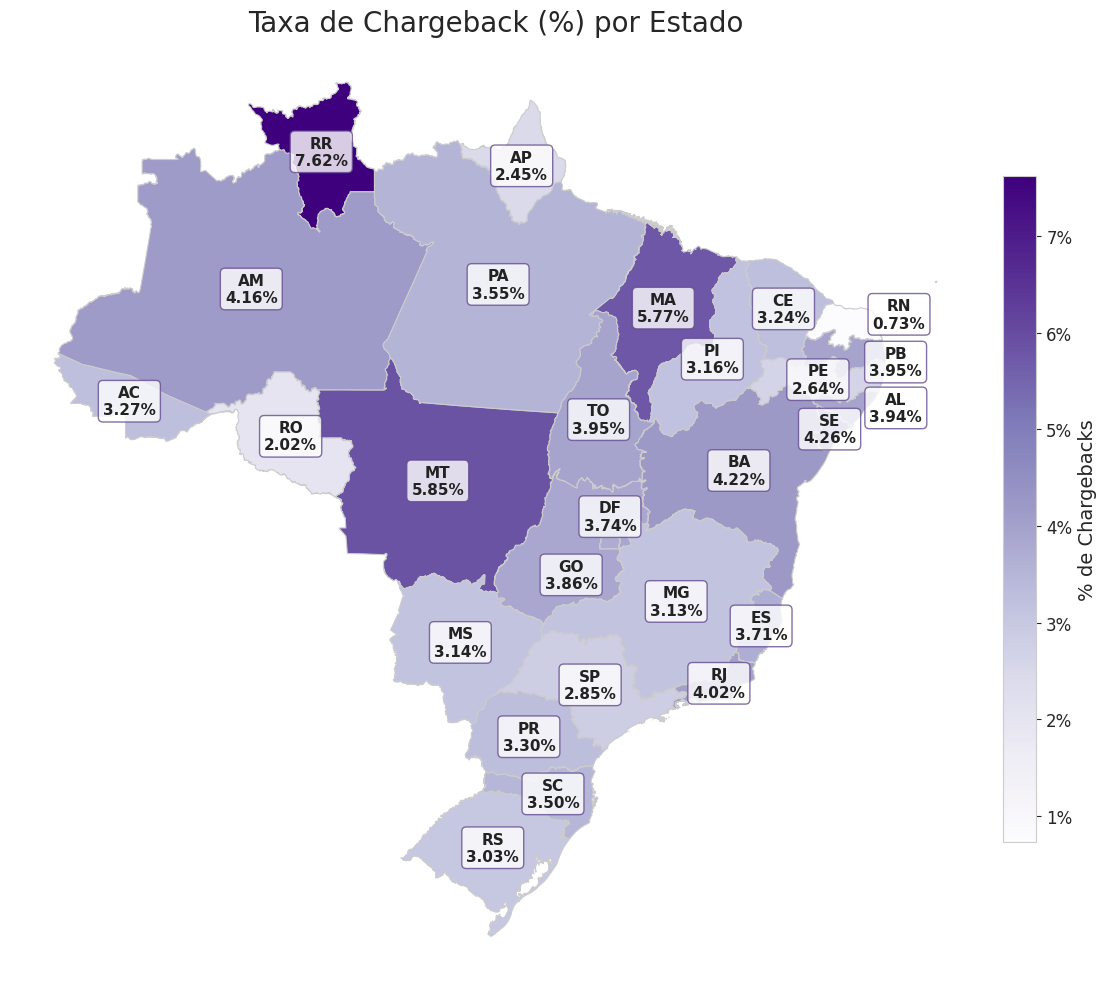

In [0]:
df = spark.sql("""
WITH chargebacks_por_estado AS (
  SELECT 
    dg.estado,
    COUNT(*) AS n_chargebacks
  FROM dim_chargebacks AS dch
  LEFT JOIN fato_transacoes AS ft
    ON ft.pedido_id = dch.chargeback_id
  LEFT JOIN dim_clientes AS dc
    USING(cliente_id)
  LEFT JOIN dim_geolocalizacao AS dg
    USING(cep_prefixo)
  WHERE dg.estado IS NOT NULL
  GROUP BY dg.estado
)
SELECT 
  dg.estado AS estado,
  ROUND(
    (any_value(cbc.n_chargebacks) / COUNT(*)) * 100,
    2
  ) AS percentual_chargebacks
FROM fato_transacoes AS ft
LEFT JOIN dim_clientes AS dc
  USING(cliente_id)
LEFT JOIN dim_geolocalizacao AS dg
  USING(cep_prefixo)
LEFT JOIN chargebacks_por_estado AS cbc
  USING(estado)
WHERE dg.estado IS NOT NULL
GROUP BY dg.estado
""")

pdf = df.toPandas()

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib as mpl

url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
gdf = gpd.read_file(url)
gdf['estado'] = gdf['sigla']
gdf = gdf.merge(pdf, on='estado', how='left')

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
norm = Normalize(
    vmin=gdf['percentual_chargebacks'].min(),
    vmax=gdf['percentual_chargebacks'].max()
)
cmap = plt.cm.Purples

gdf.plot(
    column='percentual_chargebacks',
    cmap='Purples',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=False,
    missing_kwds={
        "color": "lightgrey",
        "label": "Sem dados"
    }
)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('% de Chargebacks', fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticklabels([f"{int(t)}%" for t in cbar.get_ticks()])

ax.set_title('Taxa de Chargeback (%) por Estado', fontsize=20)
ax.axis('off')

custom_offsets = {
    'RN': (2.5, 0.5),
    'PB': (2.5, -0.4),
    'DF': (0, 1.2),
    'GO': (0, -1.2),
    'AL': (2.3, -0.1)
}
for idx, row in gdf.iterrows():
    if not pd.isnull(row['percentual_chargebacks']):
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
        sigla = row['sigla']
        if sigla in custom_offsets:
            offset_x, offset_y = custom_offsets[sigla]
            ha, va = 'center', 'center'
        else:
            offset_x, offset_y = 0, 0
            ha, va = 'center', 'center'
        ax.annotate(
            f"{sigla}\n{row['percentual_chargebacks']:.2f}%",
            xy=(x + offset_x, y + offset_y),
            ha=ha, va=va,
            fontsize=11, fontweight='bold',
            color='#222222',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#644c90", alpha=0.8)
        )

plt.tight_layout()
plt.show()